<a href="https://colab.research.google.com/github/naelrashdeen/ant-design/blob/master/pm_simple_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install pm4py
import pm4py

In [36]:
input_file_path='/content/test-log1.xes'
output_file_path='/content/output.csv'

log = pm4py.read_xes(input_file_path)
df = pm4py.convert_to_dataframe(log)
df.info()

parsing log, completed traces ::   0%|          | 0/5139 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71240 entries, 0 to 71239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   concept:name          71240 non-null  object             
 1   time:timestamp        71240 non-null  datetime64[ns, UTC]
 2   concept:title         27527 non-null  object             
 3   concept:author        21442 non-null  object             
 4   case:concept:name     71240 non-null  object             
 5   case:concept:title    71240 non-null  object             
 6   case:time:created_at  71240 non-null  datetime64[ns, UTC]
 7   case:time:updated_at  71240 non-null  datetime64[ns, UTC]
 8   case:time:closed_at   71240 non-null  datetime64[ns, UTC]
 9   case:concept:state    71240 non-null  object             
 10  concept:username      49798 non-null  object             
 11  concept:reviewer      33 non-null     object             
 12  conc

In [37]:
df = df.rename(columns={'concept:name': 'event', 'time:timestamp': 'event_createdAt', 'concept:title': 'commit_title', 'concept:author':'commit_author',
                        'case:concept:name': 'pr_id', 'case:concept:title': 'pr_title', 'case:time:created_at': 'pr_createdAt', 'case:time:updated_at': 'pr_updatedAt',
                        'case:time:closed_at': 'pr_closedAt', 'case:concept:state': 'pr_state', 'concept:username': 'event_user', 'concept:reviewer':'user_reviwer',
                        'concept:state': 'review_state', 'concept:title_first': 'label_title'})

df
df.head()

,event,event_createdAt,commit_title,commit_author,pr_id,pr_title,pr_createdAt,pr_updatedAt,pr_closedAt,pr_state,event_user,user_reviwer,review_state,label_title
0,committed,2023-11-22 13:45:12+00:00,update docker build/push/deploy action,frantuma,12285,update docker build/push/deploy action,2023-11-22 13:46:15+00:00,2023-11-22 13:47:43+00:00,2023-11-22 13:47:42+00:00,closed,NaN,NaN,NaN,NaN
1,merged,2023-11-22 13:47:42+00:00,NaN,NaN,12285,update docker build/push/deploy action,2023-11-22 13:46:15+00:00,2023-11-22 13:47:43+00:00,2023-11-22 13:47:42+00:00,closed,frantuma,NaN,NaN,NaN
2,closed,2023-11-22 13:47:42+00:00,NaN,NaN,12285,update docker build/push/deploy action,2023-11-22 13:46:15+00:00,2023-11-22 13:47:43+00:00,2023-11-22 13:47:42+00:00,closed,frantuma,NaN,NaN,NaN
3,head_ref_deleted,2023-11-22 13:47:43+00:00,NaN,NaN,12285,update docker build/push/deploy action,2023-11-22 13:46:15+00:00,2023-11-22 13:47:43+00:00,2023-11-22 13:47:42+00:00,closed,frantuma,NaN,NaN,NaN
4,committed,2023-11-22 10:12:32+00:00,prepare release 3.0.51,frantuma,12284,prepare release 3.0.51,2023-11-22 10:41:31+00:00,2023-11-22 14:00:05+00:00,2023-11-22 14:00:04+00:00,closed,NaN,NaN,NaN,NaN


In [38]:
df.info()
df.to_csv('/content/github_log.csv', sep='\t', encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71240 entries, 0 to 71239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   event            71240 non-null  object             
 1   event_createdAt  71240 non-null  datetime64[ns, UTC]
 2   commit_title     27527 non-null  object             
 3   commit_author    21442 non-null  object             
 4   pr_id            71240 non-null  object             
 5   pr_title         71240 non-null  object             
 6   pr_createdAt     71240 non-null  datetime64[ns, UTC]
 7   pr_updatedAt     71240 non-null  datetime64[ns, UTC]
 8   pr_closedAt      71240 non-null  datetime64[ns, UTC]
 9   pr_state         71240 non-null  object             
 10  event_user       49798 non-null  object             
 11  user_reviwer     33 non-null     object             
 12  review_state     855 non-null    object             
 13  label_title     

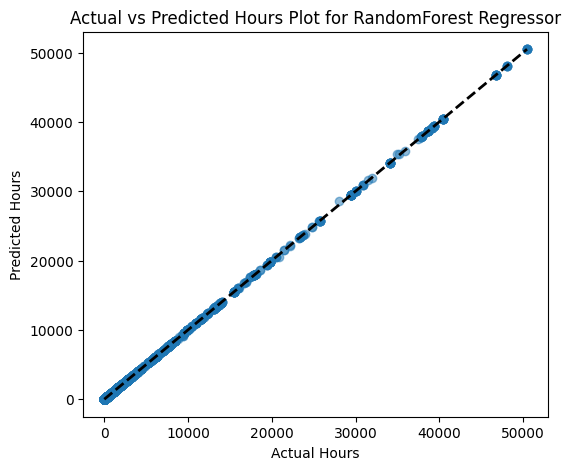

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keeping relevant columns
pr_data = df[['pr_createdAt', 'pr_updatedAt', 'pr_closedAt', 'pr_state', 'event_user']].dropna()


# Preprocessing for Regression Task
# Calculating the duration (in hours) from PR creation to closure
pr_data['hours_to_close'] = (pr_data['pr_closedAt'] - pr_data['pr_createdAt']).dt.total_seconds() / 3600

# Creating new features
pr_data['time_to_close'] = (pr_data['pr_closedAt'] - pr_data['pr_createdAt']).dt.total_seconds()

# Encoding categorical variables
le = LabelEncoder()
pr_data['event_user_encoded'] = le.fit_transform(pr_data['event_user'])

# Features for the regression model
X_reg = pr_data[['time_to_close', 'event_user_encoded']]  # using time_to_close and the encoded user as features
y_reg = pr_data['hours_to_close']

# Splitting the dataset for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Model Selection and Training for Regression
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

# Predicting on Test Set
y_pred_reg = rf_regressor.predict(X_test_reg)

# Regression Metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

mae, mse, r2

pr_data.head()

# # Calculating the average actual time to close PRs from the dataset
# average_actual_time_to_close = pr_data['hours_to_close'].mean()

# # Calculating the average predicted time to close PRs by the model
# average_predicted_time_to_close = y_pred_reg.mean()

# average_actual_time_to_close, average_predicted_time_to_close


import matplotlib.pyplot as plt

# Creating the Actual vs Predicted Values Plot for RandomForest Regressor
plt.figure(figsize=(6, 5))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Actual Hours')
plt.ylabel('Predicted Hours')
plt.title('Actual vs Predicted Hours Plot for RandomForest Regressor')
plt.show()


In [107]:
pr_data['hours_to_close'].max()

50473.43666666667